# Dependencies

In [1]:
import sys
sys.path.append('../../Scripts/tracking/')
import os
import copy
import pandas as pd
import numpy as np
import netCDF4 as nc
import CycloneModule_12_4 as md
import sys
import xarray as xr
import scipy as sp
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
import tqdm
import glob
import time

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# Set up args

In [2]:
print("Setting up environment")
verd = "12_4Test" # Detection Version
vert = 'Tracks' # Tracking Version
spres = 25 # Spatial resolution (in km)

Setting up environment


In [3]:
inpath='/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc'
outpath='/'.join(inpath.split('/')[:5])+'/postproc/tracks/'+'/'.join(inpath.split('/')[5:-1])+'/'
suppath='/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ancil/EASE2_N0_25km_Projection.nc'
variable='msl'

In [4]:
outpath += inpath.split('/')[-1].split('.')[0]

try:
    os.chdir(outpath)
except:
    os.mkdir(outpath)
    os.mkdir(outpath+'/tmp')

# Regridding

## set up args

In [5]:
rg_infile=inpath[:]
rg_gridfile=suppath[:]
rg_variable=variable[:]
rg_outfile=outpath+'/tmp/'+inpath.split('/')[-1]

## create minimal EASE2 mesh

In [6]:
print('regridding {} {} using {} grid and saving to {}'.format(rg_infile,rg_variable,rg_gridfile,rg_outfile))

ds_in = xr.open_dataset(rg_infile)
grid_out = xr.open_dataset(rg_gridfile)

# convert ds_in longitudes to -180 to 180
if ds_in[[x for x in ds_in.variables if x[:3] == 'lon'][0]].values.max() > 180:
    print('converting longitudes to -180 to 180 scale')
    ds_in = ds_in.assign_coords({[x for x in ds_in.variables if x[:3] == 'lon'][0]:(ds_in[[x for x in ds_in.variables if x[:3] == 'lon'][0]]+180)%360-180})

# Get lat/lon values (accounting for latitude / lat naming)
in_lat = ds_in[[x for x in ds_in.variables if x[:3] == 'lat'][0]].values
in_lon = ds_in[[x for x in ds_in.variables if x[:3] == 'lon'][0]].values
in_vals = ds_in[rg_variable].values

grid_lat = grid_out[[x for x in grid_out.variables if x[:3] == 'lat'][0]].values
grid_lon = grid_out[[x for x in grid_out.variables if x[:3] == 'lon'][0]].values

# if lat/lon on a regular grid, convert to mesh
if np.ndim(in_lat) == 1:
    in_lon,in_lat = np.meshgrid(in_lon,in_lat)

# Precompute Delaunay triangulation
tri = Delaunay(np.array([in_lon.flatten(),in_lat.flatten()]).T)

# Slice EASE2 grid to minimal bbox
interp = LinearNDInterpolator(tri, in_vals[0].flatten()*0)
minbox = np.nan_to_num(interp(grid_lon,grid_lat)+1).astype(bool)
U,V = np.meshgrid(grid_out.u,grid_out.v)
U_min = U[minbox].min()
U_max = U[minbox].max()
V_min = V[minbox].min()
V_max = V[minbox].max()

# generate new subgrid lat/lon mesh
subgrid_out = grid_out.sel(u=slice(U_min,U_max),v=slice(V_max,V_min))
subgrid_lat = subgrid_out[[x for x in grid_out.variables if x[:3] == 'lat'][0]].values
subgrid_lon = subgrid_out[[x for x in grid_out.variables if x[:3] == 'lon'][0]].values

regridding /gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc msl using /gf3/predict2/AWH012_LEACH_NASTORM/DATA/ancil/EASE2_N0_25km_Projection.nc grid and saving to /gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/cf/1_2022-02-10/tmp/1_2022-02-10.nc


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/_cffi_backend.cpython-37m-x86_64-linux-gnu.so: symbol ffi_type_uint32 version LIBFFI_BASE_7.0 not defined in file libffi.so.7 with link time reference
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## regrid all timesteps

In [7]:
# create empty array for regridded data
interp_vals = np.empty((in_vals.shape[0],*subgrid_out.z.shape))

# loop over first input index
for i,fld in tqdm.tqdm(enumerate(in_vals)):
    
    interp = LinearNDInterpolator(tri, fld.flatten())
    interp_vals[i] = interp(subgrid_lon,subgrid_lat)
    
# retain attributes from the original, but add in history line
update_attrs = ds_in.attrs.copy()
if 'history' in update_attrs:
    update_attrs['history'] = pd.to_datetime('today').strftime('%c')+': Regridded using scipy LinearNDInterpolator to EASE2.0 25km EU grid \n'+update_attrs['history']
else:
    update_attrs['history'] = pd.to_datetime('today').strftime('%c')+': Regridded using scipy LinearNDInterpolator to EASE2.0 25km EU grid'

# create Dataset & write to netcdf
regridded = xr.Dataset(data_vars = {rg_variable:(('time','v','u'),interp_vals),'lat':subgrid_out[[x for x in grid_out.variables if x[:3] == 'lat'][0]],'lon':subgrid_out[[x for x in grid_out.variables if x[:3] == 'lon'][0]]},
                       coords = {'time':ds_in.time,'u':subgrid_out.u,'v':subgrid_out.v},
                       attrs = update_attrs)

# if only wanting 3-hrly (or coarser) data:
regridded_mod3 = regridded.time.dt.hour.values[0]%3
regridded = regridded.sel(time=regridded.time.dt.hour%3==regridded_mod3)

regridded.to_netcdf(rg_outfile)

# also write the subgrid to a file for elevation
subgrid_out.to_netcdf('/'.join(rg_outfile.split('/')[:-1])+'/elevation_grid.nc')

print('done')

48it [00:00, 65.11it/s]


done


## reset tracking args

In [8]:
inpath=rg_outfile[:]
suppath='/'.join(rg_outfile.split('/')[:-1])+'/elevation_grid.nc'

In [9]:
## check these files all exist
if not os.path.exists(inpath):
    print('inpath does not exist')

if not os.path.exists(suppath):
    print('suppath does not exist')

# Set up parameters

## time variables

In [10]:
print("Defining parameters")
# File Variables
invar = variable[:]
ncvar = variable[:]

## NJL: automatic time variable setting
# Time Variables 
timeref_ds = xr.open_dataset(inpath,decode_times=False).time
timeref_ds1 = xr.open_dataset(inpath).time
dateref = pd.to_datetime([x for x in timeref_ds.units.split(' ') if '-' in x][0])
unit = timeref_ds.units.split(' ')[0]
calendar = timeref_ds.calendar
starttime = timeref_ds1[0].values[()]
timestep = pd.Timedelta(timeref_ds.diff('time')[0].values[()],unit=unit)
endtime = timeref_ds1[-1].values[()] + timestep
## NJL: for setting prior variable:
previous_step = starttime - timestep

try:
    starttime=pd.to_datetime(starttime)
    endtime=pd.to_datetime(endtime)
    dateref=pd.to_datetime(dateref)
    previous_step=pd.to_datetime(previous_step)
except:
    pass

convert_times_to_list = lambda x: [int(y) for y in x.strftime('%Y-%m-%d-%H-%M-%S').split('-')]
starttime = convert_times_to_list(starttime)
endtime = convert_times_to_list(endtime)
timestep = [0,0,0,timestep.seconds//3600,0,0]
dateref = convert_times_to_list(dateref)
starting_hour = starttime[3] % timestep[3]

## NJL: check if MOHC model (BOOOO)
if calendar == '360_day':
    daysBetween_dpy = 360
    daysBetween_lys = 0
    print('calendar is 360 day noleap')
elif calendar == '365_day' or calendar == 'noleap':
    daysBetween_dpy = 365
    daysBetween_lys = 0
    print('calendar is 365 day noleap')
else:
    daysBetween_dpy = 365
    daysBetween_lys = 1
    print('calendar is 365 day leap')

## if netcdf units are hours, add in an adjustment factor
if unit=='hours':
    daysBetween_adjustment = 24
else:
    daysBetween_adjustment = 1


prior = 0

Defining parameters
calendar is 365 day leap


In [11]:
print(starttime,endtime,timestep,dateref)

[2022, 2, 10, 6, 0, 0] [2022, 2, 22, 6, 0, 0] [0, 0, 0, 6, 0, 0] [1900, 1, 1, 0, 0, 0]


## tracking parameters

In [12]:
# Detection Parameters #
minsurf = 80000 # minimum reasonable value in surface tif
maxsurf = 200000 # maximum reasonable value in surface tif

# Size of kernel used to determine if a grid cell is a local minimum
##  Starting in Version 12.1, users enter a distance in km instead of the kernel
## size. This way, the kSize can adapt to different spatial resolutions. The 
## equivalent of a 3 by 3 kernel with 100 km resolution would be 100
## i.e., kSize = (2*kSizekm/spres)+1
kSizekm = 200

# Maximum fraction of neighboring grid cells with no data (Not a Number) allowed
### for a grid cell to be considered during minimum detection 
nanThresh = 0.4

# minimum slp gradient for identifying (and eliminating) weak minima:
d_slp = 750 # slp difference in Pa (use 0 to turn off)
d_dist = 1000000 # distance in m (units that match units of cellsize)

# maximum elevation for masking out high elevation minima
maxelev = 1500. # elevation in m (use 10000 to turn off)

# minimum latitude for masking out the Equator (takes absolute value!)
minlat = 5

# Contour interval (Pa; determines the interval needed to identify closed 
### contours,and therefore cyclone area)
contint = 200

# Multi-center cyclone (mcc) tolerance is the maximum ratio permitted between the
### number of unshared and total contours in a multi-centered cyclone. "Unshared"
### contours are only used by the primary center. "Shared" contours are used
### by both the primary and secondary centers.
mcctol = 0.5 # (use 0 to turn off mcc's; higher makes mcc's more likely)
# Multi-center cyclone (mcc) distance is the maximum distance (in m) two minima can
### lie apart and still be considered part of the same cyclone system
mccdist = 1200000

# Tracking Parameters #
# Maximum speed is the fastest that a cyclone center is allowed to travel; given
### in units of km/h. To be realistic, the number should be between 100 and 200.
### and probably over 125 (based on Rudeva et al. 2014). To turn off, set to 
### np.inf. Also, note that instabilities occur at temporal resolution of 1-hr.
### Tracking at 6-hr and a maxspeed of 125 km/hr is more comprable to tracking
### at 1-hr and a maxspeed of 300 km/hr (assuming spatial resolution of 50 km).
maxspeed = 150 # constant value
# maxspeed = 150*(3*math.log(timestep[3],6)+2)/timestep[3] # One example of scaling by temporal resolution

# The reduction parameter is a scaling of cyclone speed.  When tracking, the
### algorithm uses the cyclone speed and direction from the last interval to 
### estimate a "best guess" position. This parameter modifies that speed, making
### it slower. This reflects how cyclones tend to slow down as they mature. To
### turn off, set to 1.
red = 0.75

# Tracking

In [13]:
print("Loading Folders & Reference Files")
### Standard time text definitions ###
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
mons = ["01","02","03","04","05","06","07","08","09","10","11","12"]
days = ["01","02","03","04","05","06","07","08","09","10","11","12","13",\
    "14","15","16","17","18","19","20","21","22","23","24","25","26","27",\
    "28","29","30","31"]
hours = ["0000","0100","0200","0300","0400","0500","0600","0700","0800",\
    "0900","1000","1100","1200","1300","1400","1500","1600","1700","1800",\
    "1900","2000","2100","2200","2300"]

##### Ensure that folders exist to store outputs #####
detpath = outpath+"/detection"+verd
trkpath = outpath+"/tracking"+verd+vert
try:
    os.chdir(detpath)
except:
    os.mkdir(detpath)
    os.chdir(detpath)
    os.mkdir("CycloneFields")
try:
    os.chdir(trkpath)
except:
    os.mkdir(trkpath)
    os.chdir(trkpath)
    os.mkdir("CycloneTracks")
    os.mkdir("ActiveTracks")
    os.mkdir("SystemTracks")

Loading Folders & Reference Files


In [14]:
##### Read in attributes of reference files #####
projnc = nc.Dataset(suppath)

lats = projnc['lat'][:].data
lons = projnc['lon'][:].data
yDist = projnc['yDistance'][:].data
xDist = projnc['xDistance'][:].data
elev = projnc['z'][:]

# Generate mask based on latitude and elevation
mask = np.where((elev > maxelev) | (np.abs(lats) < minlat),np.nan,0)

# Convert kernel size to grid cells
kSize = int(2*kSizekm/spres)+1

# Convert max speed to max distance
maxdist = maxspeed*1000*timestep[3]

# Save Parameters
params = dict({"path":trkpath,"timestep":timestep, "dateref":dateref, "minsurf":minsurf, 
    "maxsurf":maxsurf,"kSize":kSize, "nanThresh":nanThresh, "d_slp":d_slp, \
    "d_dist":d_dist, "maxelev":maxelev, "minlat":minlat, "contint":contint, 
    "mcctol":mcctol, "mccdist":mccdist, "maxspeed":maxspeed, "red":red, "spres":spres})
pd.to_pickle(params,trkpath+"/cycloneparams.pkl")

In [15]:
start = time.perf_counter()
##### The actual detection and tracking #####
print("Cyclone Detection & Tracking")
# Print elapsed time
print(' Elapsed time:',round(time.perf_counter()-start,2),'seconds -- Starting first month')

# Load netcdf for initial time
ncf = nc.Dataset(inpath)
tlist = ncf['time'][:].data
cflist = []

t = copy.deepcopy(starttime)
while t != endtime:
    # Extract date
    Y = str(t[0])
    MM = months[t[1]-1]
    M = mons[t[1]-1]
    date = Y+M+days[t[2]-1]+"_"+hours[t[3]]

    # Load surface
    try: # If the cyclone field has already been calculated, no need to repeat
        cf = pd.read_pickle(detpath+"/CycloneFields/CF"+date+".pkl")
    except:
        # print(tlist)
        # print(md.daysBetweenDates(dateref,t))
        # print(np.where(tlist == md.daysBetweenDates(dateref,t)*24))
        surf = ncf[ncvar][np.where(tlist == md.daysBetweenDates(dateref,t,dpy=daysBetween_dpy,lys=daysBetween_lys)*daysBetween_adjustment)[0][0],:,:]
        surf = np.where((surf < minsurf) | (surf > maxsurf), np.nan, surf)
        
        # Create a cyclone field object
        cf = md.cyclonefield(md.daysBetweenDates(dateref,t,dpy=daysBetween_dpy,lys=daysBetween_lys))
        
        # Identify cyclone centers
        cf.findCenters(surf, mask, kSize, nanThresh, d_slp, d_dist, yDist, xDist, lats, lons) # Identify Cyclone Centers

        # Calculate cyclone areas (and MCCs)
        cf.findAreas(surf+mask, contint, mcctol, mccdist, lats, lons, kSize) # Calculate Cyclone Areas
    
        pd.to_pickle(cf,detpath+"/CycloneFields/CF"+date+".pkl")

    # Track Cyclones
    if t == starttime: # If this is the first time step, must initiate tracking
        if prior == 0: #If this is the first time step and there are no prior months
            ct, cf.cyclones = md.startTracks(cf.cyclones)
    
        else: #If this is the first time step but there is a prior month
            # Identify date/time of prior timestep
            tp = md.timeAdd(t,[-i for i in timestep],dpy=daysBetween_dpy,lys=daysBetween_lys)
            datep = str(tp[0]) + str(mons[tp[1]-1]) + days[tp[2]-1]+"_"+hours[tp[3]]
            cffilep = "CF"+datep+".pkl"
            
            # Load cyclone tracks and cyclone field from prior time step
            ct = pd.read_pickle(trkpath+"/ActiveTracks/activetracks"+str(tp[0])+str(mons[tp[1]-1])+".pkl")
            cf1 = pd.read_pickle(detpath+"/CycloneFields/"+cffilep)
            md.realignPriorTID(ct,cf1)
            
            # move into normal tracking
            ct, cf = md.trackCyclones(cf1,cf,ct,maxdist,red,timestep[3])
    
    else: #If this isn't the first time step, just keep tracking
        ct, cf = md.trackCyclones(cf1,cf,ct,maxdist,red,timestep[3])
    
    # Increment time step indicator
    t = md.timeAdd(t,timestep,dpy=daysBetween_dpy,lys=daysBetween_lys)
    cf1 = copy.deepcopy(cf)
        
    # Save Tracks (at the end of each month)
    if t == endtime: # If the next timestep is the 0th hour of the 1st day of a month,
        print("  Exporting Tracks for " + Y + " " + MM + ' -- Elapsed Time: ' + str(round(time.perf_counter()-start,2)) + ' seconds')
        ct, ct_inactive = md.splitActiveTracks(ct, cf1)
        
        # Export inactive tracks
        pd.to_pickle(ct_inactive+ct,trkpath+"/CycloneTracks/cyclonetracks"+Y+M+".pkl")
        pd.to_pickle(ct,trkpath+"/ActiveTracks/activetracks"+Y+M+".pkl")

print("Complete")

Cyclone Detection & Tracking
 Elapsed time: 0.0 seconds -- Starting first month
  Exporting Tracks for 2022 Feb -- Elapsed Time: 8.7 seconds
Complete


# Conversion to cyclone system tracks

## add in additional args

In [16]:
refpath=inpath[:]
inpath=outpath+'/tracking12_4TestTracks/'
outpath=inpath[:]

## extra parameters
subset=""
rg=1
reftime = copy.deepcopy(starttime)

## create system tracks

In [17]:
print("Main Analysis")

mt = starttime

# Extract date
Y = str(mt[0])
M = mons[mt[1]-1]
print (" " + Y + " - " + M)

# Load Cyclone Tracks
ct = pd.read_pickle(inpath+"/CycloneTracks/"+subset+"cyclonetracks"+Y+M+".pkl")

# Create System Tracks
cs, cs0 = md.cTrack2sTrack(ct,[],dateref,rg,dpy=daysBetween_dpy,lyb=daysBetween_lys)
pd.to_pickle(cs,inpath+"/SystemTracks/"+subset+"systemtracks"+Y+M+".pkl")

print('Elapsed time:',round(time.perf_counter()-start,2),'seconds')

Main Analysis
 2022 - 02
Elapsed time: 9.43 seconds


## postprocess to hdf

In [18]:
systemtracks = glob.glob(inpath+"SystemTracks/*.pkl")

for track in systemtracks:
    
    fname = track.split('/')[-1].split('.')[0]
    fyear = int(fname[-6:-2])
    fmon = int(fname[-2:])
    fpath = '/'.join(track.split('/')[:-1])
    
    pkl = pd.read_pickle(track)
    concat = pd.concat([x.data.assign(sid=x.sid,year=fyear,mon=fmon,uid=fyear+fmon+x.sid) for x in pkl])
    
    concat['uid'] = concat.year.apply(lambda x: '{:04d}'.format(x))+concat.mon.apply(lambda x: '{:02d}'.format(x))+concat.sid.apply(lambda x: '{:03d}'.format(x))
    concat['date'] = pd.TimedeltaIndex(concat.time,unit='days') + pd.to_datetime('{}-{}-{}'.format(*dateref[:3]))
    concat['dDist'] = np.sqrt((concat.Dx*spres)**2+(concat.Dy*spres)**2)
    
    concat.to_hdf('/'.join(fpath.split('/')[:-3])+'/'+fpath.split('/')[-3]+'.h5','systemtracks')

# check output if required

In [19]:
import seaborn as sn
import cartopy.crs as crs
import matplotlib.pyplot as plt

In [20]:
df = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.h5')

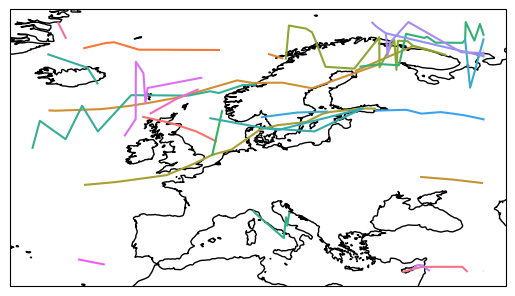

In [21]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()))

sn.lineplot(data=df,x='long',y='lat',hue='uid',legend=False)

ax.coastlines()

In [2]:
import xarray as xr

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [3]:
ds0=xr.open_dataset('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/1_2022-02-07_1.nc')
ds1=xr.open_dataset('/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-07.nc')

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/_cffi_backend.cpython-37m-x86_64-linux-gnu.so: symbol ffi_type_uint32 version LIBFFI_BASE_7.0 not defined in file libffi.so.7 with link time reference
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
